In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, show_comparison, save_gif, chars_to_ids, centering_image
from get_data.package import pickle_interpolation_data

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

# from_model_path = './model_checkpoint/new_training/'
from_model_path = './model_checkpoint/old_training'
data_dir = './dataset/new_training'
fixed_dir = './fixed_sample/new_training'

### 200epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']
# restore = ['200-0611-14:22-Encoder.pkl', '200-0611-14:22-Decoder.pkl', '200-0611-14:22-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

---

# Save Generated Outputs
- generated될 character를 정해서 dictionary에 담은 후 저장

### `fixed_char_ids` : 원하는 글씨 32글자 정하기

In [7]:
chars = '앉골헤정삽겕국벡캳찬앟닌믹댜틸솜설읻샣네발뷰댶뱤화뷘데칭내컁병실먊엩민퍼뷴옺댕암'
len(chars)

40

In [8]:
selected_chars = chars_to_ids(chars)
print(selected_chars)

[6473, 232, 10724, 7189, 5309, 149, 365, 4257, 8883, 8236, 6495, 1740, 4089, 1820, 9976, 5532, 5412, 7035, 5347, 1316, 4124, 4592, 1846, 4196, 10836, 4568, 1904, 8813, 1204, 8897, 4305, 5860, 3594, 6633, 4092, 10108, 4596, 6714, 1813, 6484]


In [9]:
fixed_char_ids = selected_chars
fixed_char_ids.sort()
fixed_char_ids = torch.tensor(fixed_char_ids)
torch.save(fixed_char_ids, os.path.join(data_dir, 'fixed_char_ids.pkl'))

In [10]:
fixed_char_ids = torch.load(os.path.join(data_dir, 'fixed_char_ids.pkl'))
fixed_char_ids = fixed_char_ids.numpy()
print(len(fixed_char_ids))
fixed_char_ids

40


array([  149,   232,   365,  1204,  1316,  1740,  1813,  1820,  1846,
        1904,  3594,  4089,  4092,  4124,  4196,  4257,  4305,  4568,
        4592,  4596,  5309,  5347,  5412,  5532,  5860,  6473,  6484,
        6495,  6633,  6714,  7035,  7189,  8236,  8813,  8883,  8897,
        9976, 10108, 10724, 10836])

In [11]:
except_ = [1, 2, 3, 4, 22, 23, 24]
font_filter = [i for i in range(25)if i not in except_]
print(len(font_filter))
font_filter

18


[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### `interpolation_data.obj` : 24개의 글자 각각 18가지 폰트 이미지 모두 저장하기


- 각 폰트(18종류) 당 32글자이므로 : 432개 파일

In [12]:
from_dir = './get_data/hangul-dataset-11172/'
save_path = './interpolation/dataset/interpolation_data.obj'

pickle_interpolation_data(from_dir, save_path, fixed_char_ids, font_filter)

data num: 720


## Load Data 
### 18fonts x 24chars = 432개 data 

In [13]:
data_provider = TrainDataProvider(data_dir, val=False, filter_by_font=font_filter)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 75234 examples
filter by label -> [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
train examples -> 66645
total batches: 3703


### `all_fonts` : font_ids 를 key로 갖는 dictionary

In [18]:
train_batch_iter = data_provider.get_train_iter(BATCH_SIZE, with_charid=True)

results = {i: {j: None for j in fixed_char_ids} for i in font_filter}

for i, batch in enumerate(train_batch_iter):
    font_ids, char_ids, batch_images = batch
    batch_images = batch_images.cuda()
    embedding_ids = font_ids
    
    # target / source images
    real_targets = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    real_sources = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
    
    # generate fake image
    fake_targets, encoded_sources, encode_layers = Generator(real_sources, En, De, embeddings, \
                                                             embedding_ids, GPU=GPU, encode_layers=True)

    # save fake images by filtering with fonts
    for data in zip(font_ids, char_ids, encoded_sources, real_sources, real_targets, fake_targets):
        fontid, charid, encoded, real_S, real_T, fake_T = data
        real_S = real_S.cpu().detach().numpy()
        real_S = centering_image(real_S.reshape(128, 128), resize_fix=90)
        real_T = real_T.cpu().detach().numpy()
        real_T = centering_image(real_T.reshape(128, 128), resize_fix=90)
        fake_T = fake_T.cpu().detach().numpy()
        fake_T = centering_image(fake_T.reshape(128, 128), resize_fix=90)
        # (0)idx, (1)encoded, (2)layers, (3)real_source, (4)real_target, (5)fake_target 순서대로 저장
        results[fontid][charid] = [encoded, encode_layers, real_S, real_T, fake_T]
    if i == 25:
        break

In [19]:
results[5].keys()

dict_keys([9985, 1813, 7304, 3594, 4092, 8813, 8464, 8408, 149, 10904, 4124, 1440, 4257, 10075, 1316, 8230, 7419, 1820, 8236, 10836, 9080, 8883, 1204, 4592, 1846, 5047, 10484, 6714, 187, 5309, 8897, 1988, 7094, 6473, 4196, 1740, 10317, 4305, 3667, 6484, 3797, 2519, 4568, 5860, 987, 186, 6495, 5347, 10724, 5412, 232, 6633, 365, 694, 1904, 4596, 10486, 9976, 4089, 5532, 7035, 10108, 3580, 7189])

In [20]:
for fontid in font_filter:
    print('font [%d] 개수:' % fontid, len(results[fontid]))

font [0] 개수: 66
font [5] 개수: 64
font [6] 개수: 54
font [7] 개수: 71
font [8] 개수: 64
font [9] 개수: 63
font [10] 개수: 64
font [11] 개수: 67
font [12] 개수: 63
font [13] 개수: 62
font [14] 개수: 65
font [15] 개수: 70
font [16] 개수: 65
font [17] 개수: 65
font [18] 개수: 75
font [19] 개수: 69
font [20] 개수: 67
font [21] 개수: 74


- 각 폰트에 대해 32개 글자씩 모두 만들어진 것 확인!

## Fake / Real 각자 저장하기

```
results = {
     'font_id': {'charid': [(0)encoded, (1)layers, (2)real_source, (3)real_target, (4)fake_target]}
}
```

ValueError: num must be 1 <= num <= 60, not 61

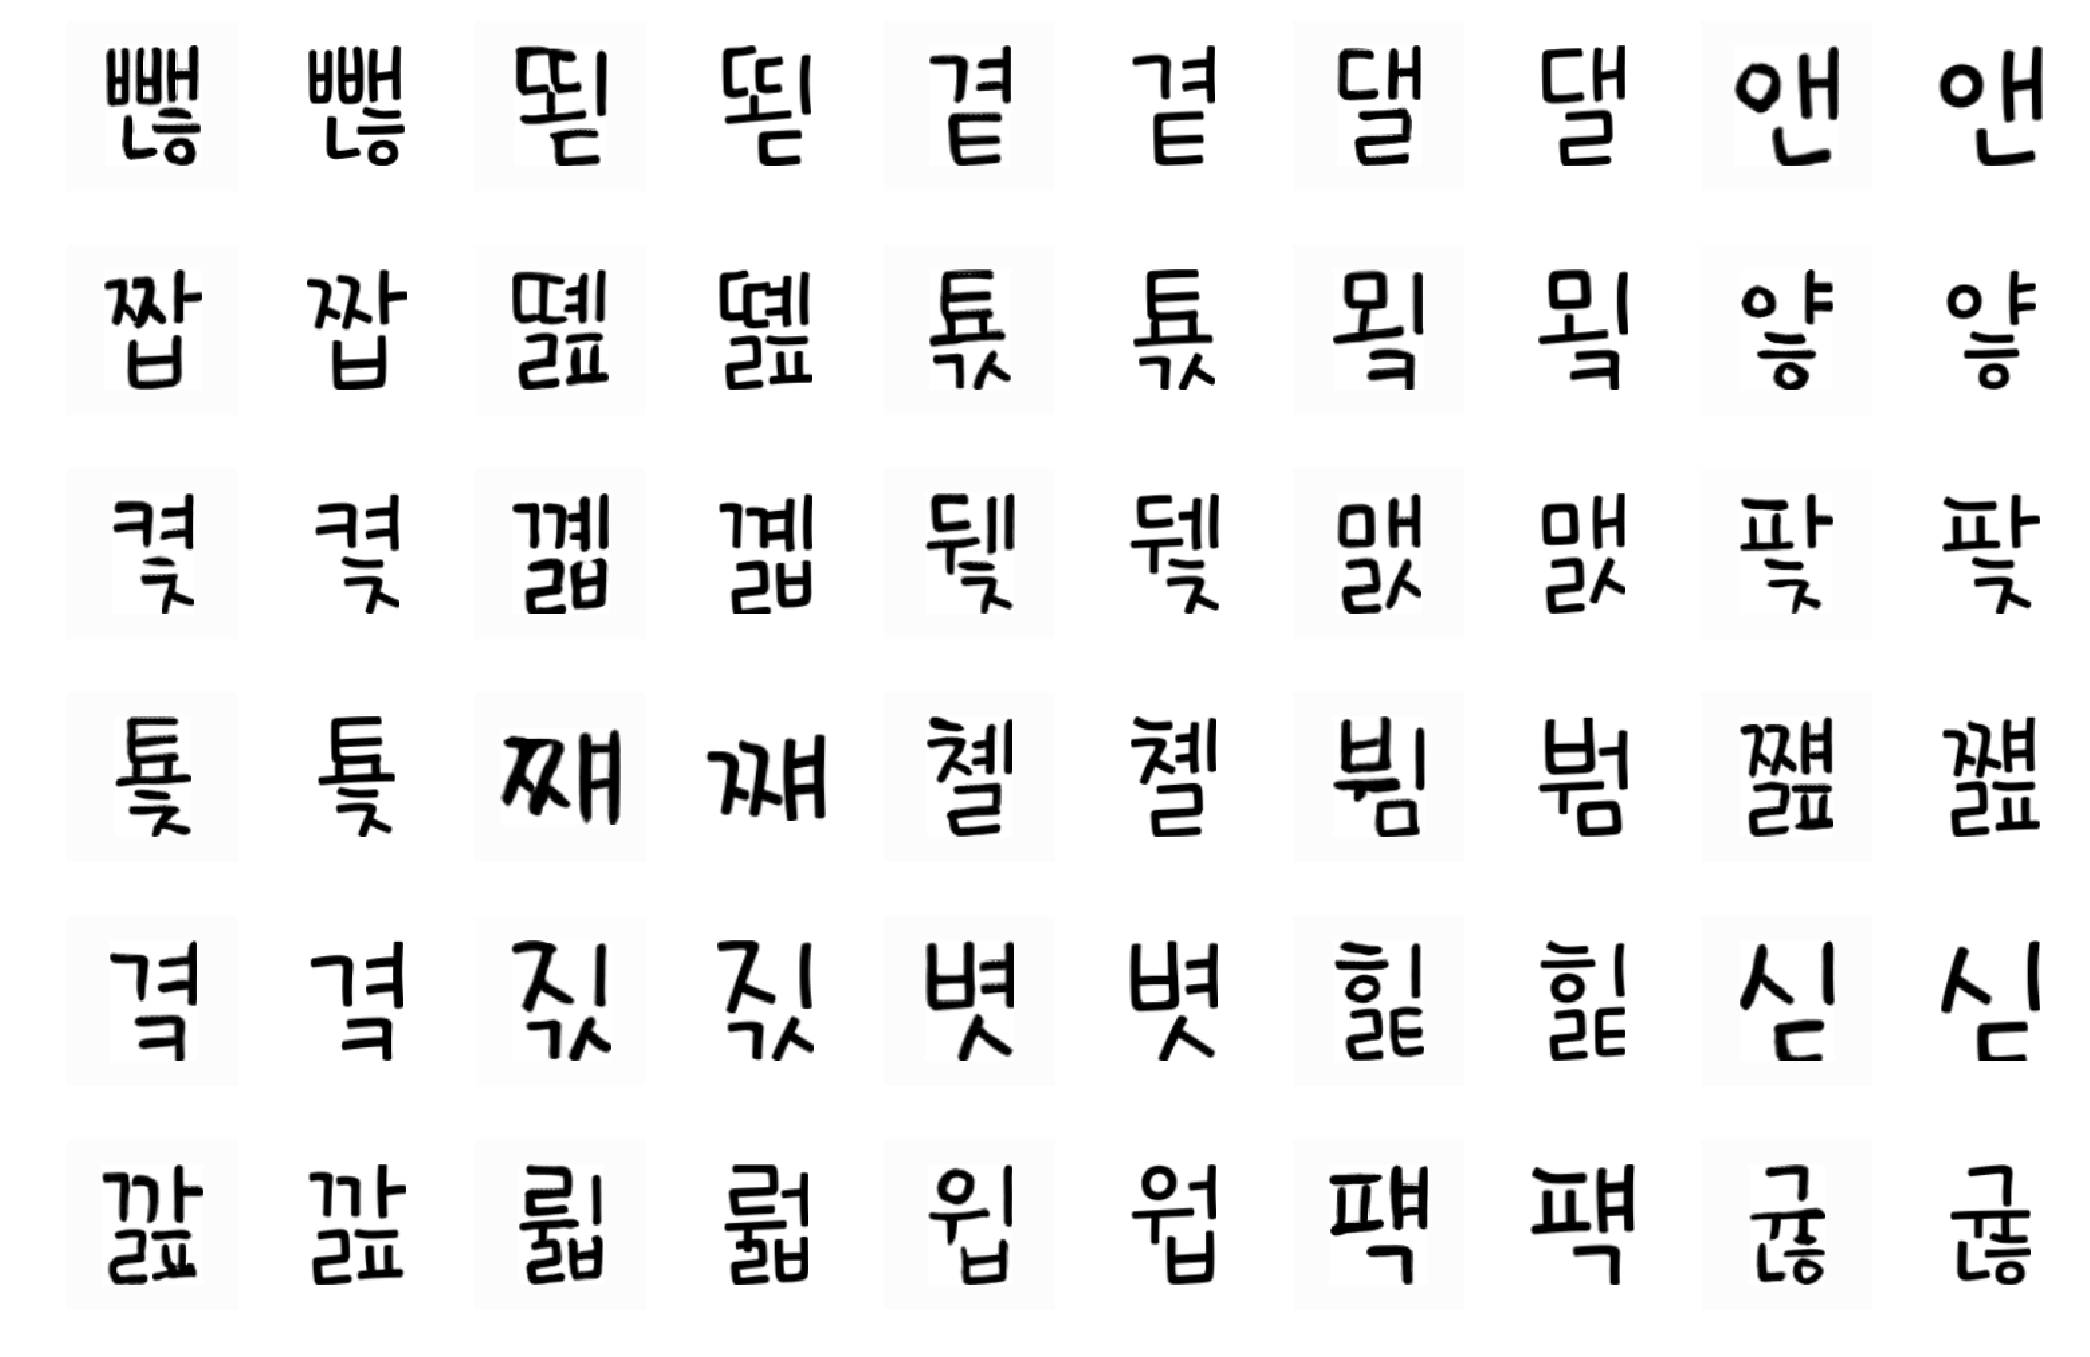

In [30]:
plt.figure(figsize=(18, 12))

font_id = 21

count = 0
for idx, charid in enumerate(results[font_id].keys()):
    if results[font_id][charid]:
        plt.subplot(6, 10, count+1)
        plt.imshow(results[font_id][charid][4].reshape(128, 128), cmap='gray')
        plt.axis('off')
        count += 1
        plt.subplot(6, 10, count+1)
        plt.imshow(results[font_id][charid][3].reshape(128, 128), cmap='gray')
        plt.axis('off')
        count += 1
plt.show()

- 나머지는 image로 save 해두기

### Fake image save

In [19]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    fake_image = torch.tensor(np.array([results[fontid][charid][4] for charid in fixed_char_ids]))
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(fake_image.data), \
               os.path.join(save_path, '%s_fake.png' % str(fontid)), \
               nrow=8, pad_value=255)

TypeError: Cannot handle this data type

### Real Target image save

In [19]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    real_image = torch.tensor(np.array([results[fontid][charid][3] for charid in fixed_char_ids]))
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(real_image.data), \
               os.path.join(save_path, '%s_real.png' % str(fontid)), \
               nrow=4, pad_value=255)

## Fake + Real 같이 저장하기

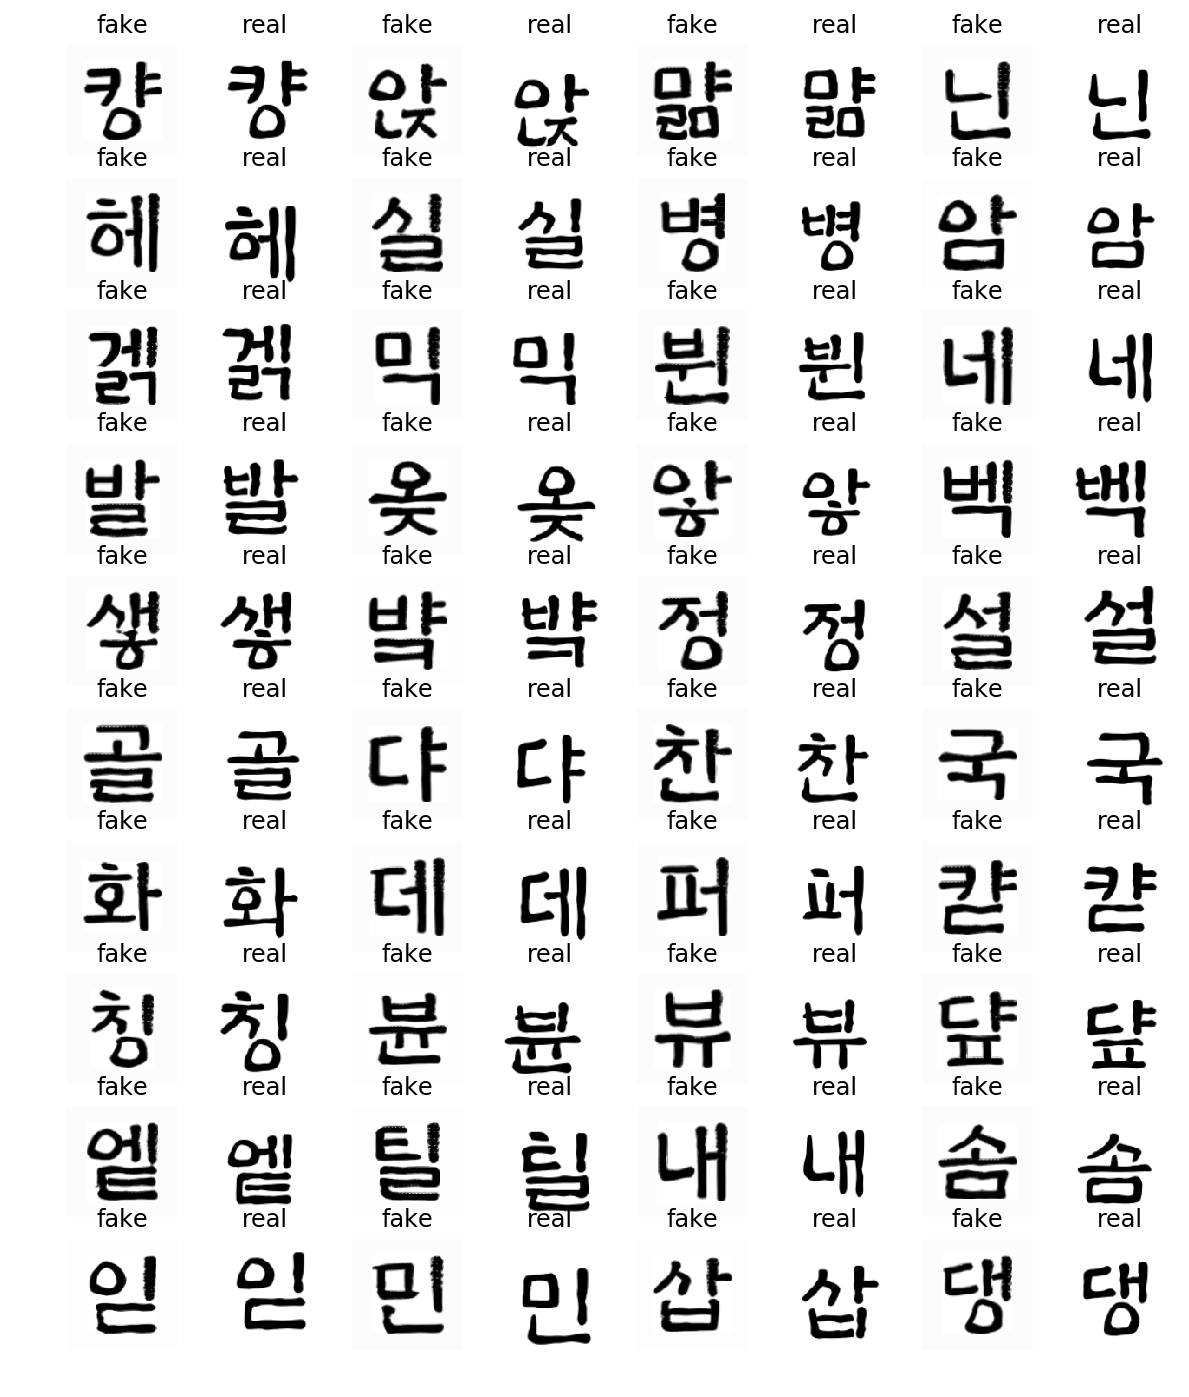

In [25]:
plt.figure(figsize=(10, 12))

for idx, charid in enumerate(results[5].keys()):
    plt.subplot(10, 8, 2*idx+1)
    plt.imshow(results[5][charid][4].reshape(128, 128), cmap='gray')
    plt.title('fake')
    plt.axis('off')

    plt.subplot(10, 8, 2*idx+2)
    plt.imshow(results[5][charid][3].reshape(128, 128), cmap='gray')
    plt.title('real')
    plt.axis('off')
plt.show()

In [21]:
save_path = './output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

for fontid in font_filter:
    fake_image = [results[fontid][charid][4] for charid in fixed_char_ids]
    real_image = [results[fontid][charid][3] for charid in fixed_char_ids]
    fake_real_images = np.array([[i, j] for i, j in zip(fake_image, real_image)])
    fake_real_images = torch.tensor(fake_real_images.reshape(48, 1, 128, 128))
    
    if len(str(fontid)) == 1:
        fontid = '0' + str(fontid)
    save_image(denorm_image(fake_real_images.data), \
               os.path.join(save_path, '%s_fake_real.png' % str(fontid)), \
               nrow=6, pad_value=255)

---

## old training GIF 생성

In [33]:
image_path = './fixed_fake_old_training'
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))

In [347]:
sorted_files = []

In [348]:
epoch_1 = [filenames[8]] + filenames[:8]
sorted_files += epoch_1

In [349]:
epoch_2 = [filenames[209]] + filenames[201:209]
sorted_files += epoch_2

In [350]:
epoch_3 = [filenames[308]]
sorted_files += epoch_3

In [351]:
epoch_4 = [filenames[407]]
sorted_files += epoch_4

In [352]:
epoch_5 = [filenames[506]]
sorted_files += epoch_5

In [353]:
epoch_6_10 = [filenames[605], filenames[704], filenames[740], filenames[761], filenames[17]]
sorted_files += epoch_6_10

In [354]:
epoch_20_100 = [filenames[210], filenames[410], filenames[608], filenames[707], filenames[770], filenames[18]]
sorted_files += epoch_20_100

In [355]:
epoch_110_150 = [filenames[47], filenames[76], filenames[105], filenames[115], filenames[134], filenames[138], \
                 filenames[144], filenames[146], filenames[148], filenames[150], filenames[152], filenames[163]]
sorted_files += epoch_110_150

In [356]:
len(sorted_files)

44

In [357]:
gif_path = './gifz/'
if not os.path.exists(gif_path):
    os.mkdir(gif_path)
file_name = 'old_training.gif'

images = []
for filename in sorted_files:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(gif_path, file_name), images)